# Variational Autoencoders

This notebook implements a basic variational autoencoder on a toy dataset so we are able to visualise the relevant representations.

## A note on differentiable sampling

In order for the gradients of quantities computed by sampling to be correctly computed, samples should be reparameterised. 

As a short example, imagine computing $E_{q}[ln \ q(z)]$. I can compute this by Monte Carlo, by sampling from q, putting the sampled z into the $ln \ q(z)$ function, and averaging the results. However, there is a double dependency on the parameters of q here - once inside the log, and once in the sampling procedure. If we move the mean of q, it affects both our samples and the value of the log function.

For a normal, we can encode the dependency using the reparameterisation trick.

If we sample from a standard gaussian $m \sim \mathcal{N}(0,1)$, we can use this sample to sample from any gaussian $\mathcal{N}(\mu,\sigma^{2})$ by $z=\mu + \sigma m$

In [19]:
import torch
from torch import nn
from torch.autograd import Variable

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-darkgrid')

In [2]:
representation_size = 2
input_size = 4
n_samples = 2000
batch_size = 5

In [3]:
n_samples_per_batch = n_samples//input_size

y = np.array([i for i in range(input_size)  for _ in range(n_samples_per_batch)])

d = np.identity(input_size)
x = np.array([d[i] for i in y], dtype=np.float32)

In [4]:
print(x[[10, 58 ,610, 790, 1123, 1258, 1506, 1988]])

[[ 1.  0.  0.  0.]
 [ 1.  0.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  0.  0.  1.]
 [ 0.  0.  0.  1.]]


In [5]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.en1 = nn.Linear(input_size, 200)
        self.en_mu = nn.Linear(200, representation_size)
        self.en_std = nn.Linear(200, representation_size)
        self.de1 = nn.Linear(representation_size, 200)
        self.de2 = nn.Linear(200, input_size)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
    def encode(self, x):
        """Encode a batch of samples, and return posterior parameters for each point."""
        h1 = self.relu(self.en1(x))
        return self.en_mu(h1), self.en_std(h1)
    
    def decode(self, z):
        """Decode a batch of latent variables"""
        
        h2 = self.relu(self.de1(z))
        return self.sigmoid(self.de2(h2))
    
    def reparam(self, mu, logvar):
        """Reparameterisation trick to sample z values. 
        This is stochastic during training,  and returns the mode during evaluation."""
        
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = Variable(std.data.new(std.size()).normal_())
            return eps.mul(std).add_(mu)
        else:
            return mu
            
    
    def forward(self, x):
        """Takes a batch of samples, encodes them, and then decodes them again to compare."""
        mu, logvar = self.encode(x.view(-1, input_size))
        z = self.reparam(mu, logvar)
        return self.decode(z), mu, logvar
    
    def loss(self, reconstruction, x, mu, logvar):
        """ELBO assuming entries of x are binary variables, with closed form KLD."""
        
        bce = torch.nn.functional.binary_cross_entropy(reconstruction, x.view(-1, input_size))
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        # Normalise by same number of elements as in reconstruction
        KLD /= x.view(-1, input_size).data.shape[0] * input_size

        return bce + KLD
    
    def get_z(self, x):
        """Encode a batch of data points, x, into their z representations."""
        
        mu, logvar = self.encode(x.view(-1, input_size))
        return self.reparam(mu, logvar)

In [6]:
model = VAE()

In [7]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [29]:
def train(epoch, batches_per_epoch = 501, log_interval=500):
    model.train()
    
    ind = np.arange(x.shape[0])
    for i in range(batches_per_epoch):
        data = torch.from_numpy(x[np.random.choice(ind, size=batch_size)])
        data = Variable(data, requires_grad=False)
        
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        
        loss = model.loss(recon_batch, data, mu, logvar)
        loss.backward()
        
        optimizer.step()
        if (i % log_interval == 0) and (epoch % 5 ==0):
            #Print progress
            print('Train Epoch: {} [{}/{}]\tLoss: {:.6f}'.format(
                epoch, i * batch_size, batch_size*batches_per_epoch,
                loss.data[0] / len(data)))



In [30]:
print_examples = False #Change to true if you want to see some examples at each step!
for epoch in range(1, 30):
    train(epoch)
    if print_examples:
        test(epoch)

Train Epoch: 5 [0/2505]	Loss: 0.071952
Train Epoch: 5 [2500/2505]	Loss: 0.066423
Train Epoch: 10 [0/2505]	Loss: 0.118553
Train Epoch: 10 [2500/2505]	Loss: 0.070104
Train Epoch: 15 [0/2505]	Loss: 0.131283
Train Epoch: 15 [2500/2505]	Loss: 0.099707
Train Epoch: 20 [0/2505]	Loss: 0.086306
Train Epoch: 20 [2500/2505]	Loss: 0.070170
Train Epoch: 25 [0/2505]	Loss: 0.069376
Train Epoch: 25 [2500/2505]	Loss: 0.073217


In [31]:
data = Variable(torch.from_numpy(x), requires_grad=False)
model.train()
zs = model.get_z(data).data.numpy()

In [32]:
colors = np.array(['r', 'g', 'b', 'y'])

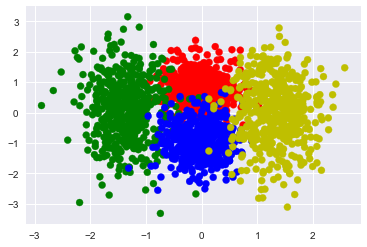

In [33]:
plt.scatter(zs[:,0], zs[:, 1], c=colors[y])

# Summary

In this notebook, we have shown how we can learn joint and posterior distributions over a latent variable using VAEs, and how the latent variable has analogues to a traditional autoencoder.